<a href="https://colab.research.google.com/github/Evan-eng/anthropic_superposition_experiment_recreation/blob/main/demonstrating_superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, replace
from tqdm.notebook import trange

In [8]:
@dataclass
class Config:
  features: int
  hidden: int
  instances: int
  importance: float
  sparsity: float

# Define linear model where
# layer 1: h = Wx
# layer 2: x' = W^T h + b
class linear_model(nn.Module):
  def __init__(self, config, feature_probabilities, importance):
    super().__init__()

    self.config = config
    self.feature_probabilities = feature_probabilities
    self.importance = importance

    self.layer1 = nn.Linear(config.features, config.hidden, bias=False)
    self.layer2 = nn.Linear(config.hidden, config.features)
    self.layer2.weight = nn.Parameter(self.layer1.weight.T.float())

  def forward(self, x):
    x = x.float()
    h = self.layer1(x)
    return self.layer2(h)


# Define ReLU model where
# layer 1: h = Wx
# layer 2: x' = relu(W^T h + b)
class relu_model(nn.Module):
  def __init__(self, config, feature_probabilities, importance):
    super().__init__()

    self.config = config
    self.feature_probabilities = feature_probabilities
    self.importance = importance

    self.layer1 = nn.Linear(config.features, config.hidden, bias=False)
    self.layer2 = nn.Linear(config.hidden, config.features)
    self.relu = nn.ReLU()
    self.layer2.weight = nn.Parameter(self.layer1.weight.T.float())

  def forward(self, x):
    x = x.float()
    h = self.layer1(x)
    return self.relu(self.layer2(h))

def custom_loss(x, x_prime, importance):
    return torch.sum(importance * ((x - x_prime) ** 2))

def optimize(model, steps=10000, lr=1e-4):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    x_instances = model.feature_probabilities

    for i in range(steps):
        optimizer.zero_grad()
        losses = []
        for x in x_instances:
            output = model(x)
            loss = custom_loss(x, output, model.importance)
            losses.append(loss)
        total_loss = sum(losses)
        total_loss.backward()
        optimizer.step()



# Generate a feature vector x where x_i = 0 with p(s) and is otherwise uniformly
# distributed between [0, 1]
def x_input(n, s):
    return torch.tensor([random.uniform(0, 1) if random.random() >= s else 0 for _ in range(n)])


# Generate importance tensor where I_i = 0.9 ^ i
def importance(n, I):
  return torch.pow(torch.tensor(.7), torch.arange(20))

config = Config(features=20, hidden=5, importance=0.9, sparsity = .9, instances = 20)

In [9]:
x_instances = [x_input(config.features, config.sparsity) for _ in range(config.instances)]
imp = importance(config.features, config.importance)

# Initialize the linear model
relu_model = relu_model(config, x_instances, imp)

# prior_weight = relu_model.layer2.weight.clone().detach().numpy()

# Optimize the model
optimize(relu_model)

# Get learned values
W2 = relu_model.layer2.weight.detach().numpy()
b2 = relu_model.layer2.bias.detach().numpy()

# print(prior_weight - W2)
# print(b2)

relu_result = np.dot(W2, W2.T)

In [10]:
x_instances = [x_input(config.features, config.sparsity) for _ in range(config.instances)]
imp = importance(config.features, config.importance)

# Initialize the linear model
linear_model = linear_model(config, x_instances, imp)

# prior_weight1 = linear_model.layer2.weight.clone().detach().numpy()

# Optimize the model
optimize(linear_model)

# Get learned values
W1 = linear_model.layer2.weight.detach().numpy()
b1 = linear_model.layer2.bias.detach().numpy()

#print(prior_weight1 - W1)
#print(b1)

linear_result = np.dot(W1, W1.T)

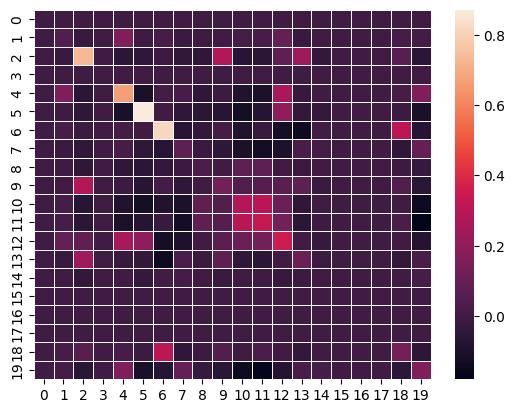

In [11]:
import seaborn as sns

ax = sns.heatmap(linear_result, linewidth=0.5)
plt.show()

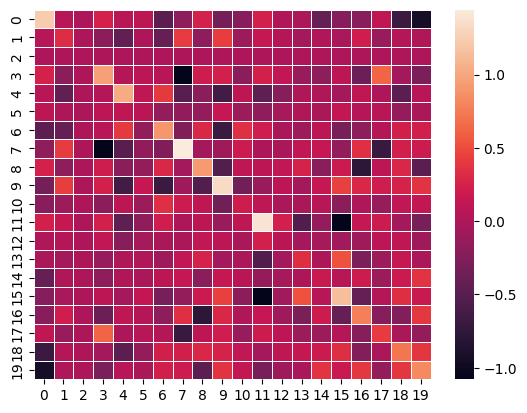

In [12]:
ax = sns.heatmap(relu_result, linewidth=0.5)
plt.show()